In [1]:
# import some common libraries
import numpy as np
import cv2
import random
import os
import matplotlib.pyplot as plt

from efootball.src.classes.models.detectron2_field.ModelField import FieldDetector
from efootball.src.classes.models.detectron2_person.ModelPerson import PersonDetector 

c:\Users\ferna\anaconda3\envs\efootball\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
person_detector = PersonDetector(0.5)
field_detector = FieldDetector(0.5)

[02/02 22:39:30 d2.checkpoint.c2_model_loading]: Following weights matched with model:
| Names in Model                                  | Names in Checkpoint                                                                                  | Shapes                                          |
|:------------------------------------------------|:-----------------------------------------------------------------------------------------------------|:------------------------------------------------|
| backbone.bottom_up.res2.0.conv1.*               | backbone.bottom_up.res2.0.conv1.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,1,1)             |
| backbone.bottom_up.res2.0.conv2.*               | backbone.bottom_up.res2.0.conv2.{norm.bias,norm.running_mean,norm.running_var,norm.weight,weight}    | (64,) (64,) (64,) (64,) (64,64,3,3)             |
| backbone.bottom_up.res2.0.conv3.*               | backbone.bottom_up.res2.0.conv3.{norm.bia

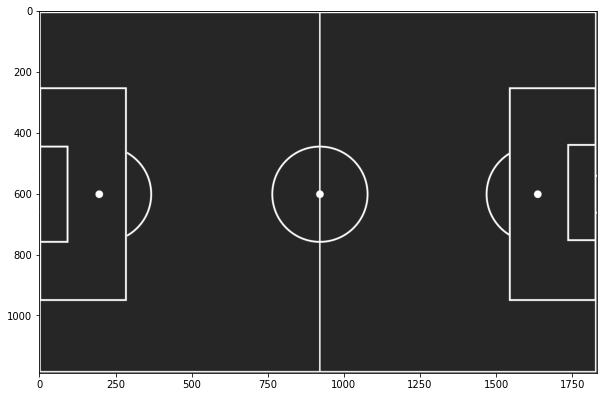

In [3]:
# Read the 2D image of the football field
img2d = cv2.imread("C:/Users/ferna/OneDrive/Documentos/Insper/Efootball/efootball/src/img/football_field.png")
gray2d= cv2.cvtColor(img2d,cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(10,20))
plt.imshow(gray2d, cmap='gray')
plt.show()

In [4]:
img3d = cv2.imread("C:/Users/ferna/OneDrive/Documentos/Insper/Efootball/data/frames/10.png")
field_rgb = cv2.cvtColor(img3d, cv2.COLOR_BGR2RGB)

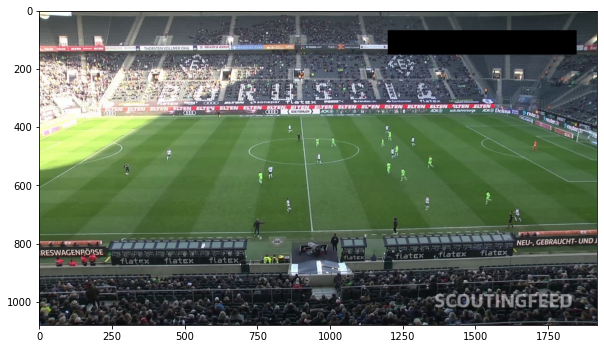

In [5]:
plt.figure(figsize=(10,20))
plt.imshow(field_rgb)
plt.show()

In [6]:
field = field_detector.removeBackground(img3d)

c:\Users\ferna\anaconda3\envs\efootball\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


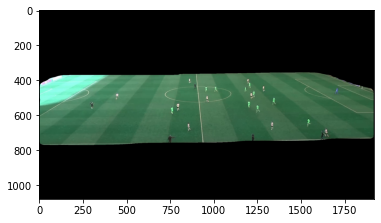

In [7]:
plt.imshow(field, cmap='gray')
plt.show()

In [8]:
persons = person_detector.detectPersons(field)

In [9]:
# Read the 3D image of the football field
img3d = field.copy()
gray3d= cv2.cvtColor(img3d,cv2.COLOR_BGR2GRAY)

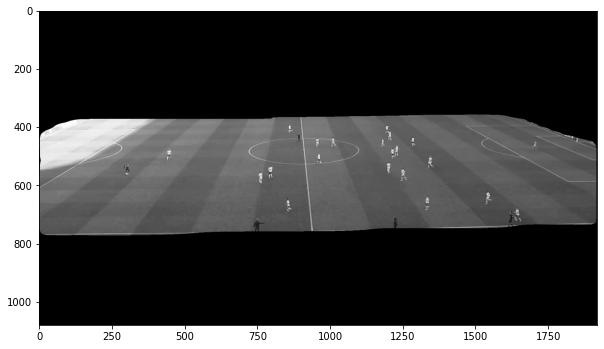

In [10]:
plt.figure(figsize=(10,20))
plt.imshow(gray3d, cmap='gray')
plt.show()

In [11]:
edges = cv2.Canny(gray3d, 50, 150)
edges = edges/255

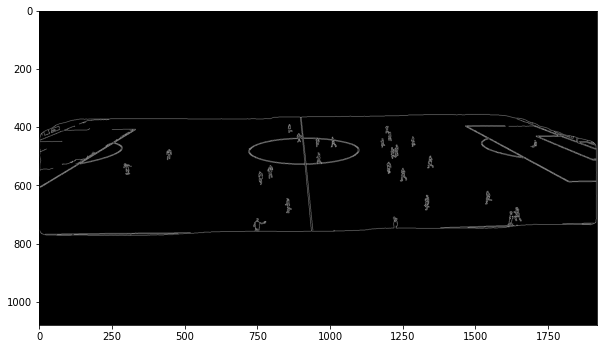

In [12]:
plt.figure(figsize=(10,20))
plt.imshow(edges, cmap='gray')
plt.show()

In [13]:
#create a white mask to start with
person_mask = np.zeros_like(edges)

In [14]:
for i in range(len(persons['masks'])):
    temp_mask = persons['masks'][i].cpu().numpy()
    person_mask[temp_mask] = 1

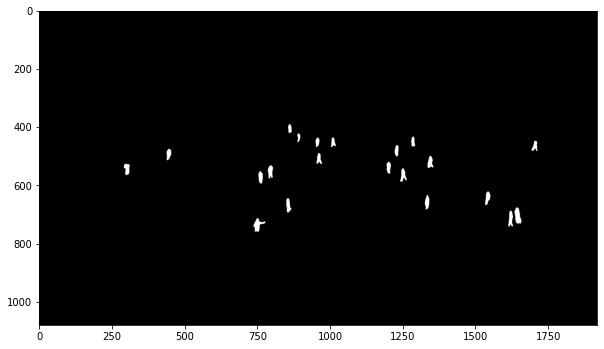

In [15]:
plt.figure(figsize=(10,20))
plt.imshow(person_mask, cmap='gray')
plt.show()

In [16]:
kernel = np.ones((4,4),np.uint8)
dilated_person_mask = cv2.dilate(person_mask, kernel, iterations = 2).astype(np.uint8)

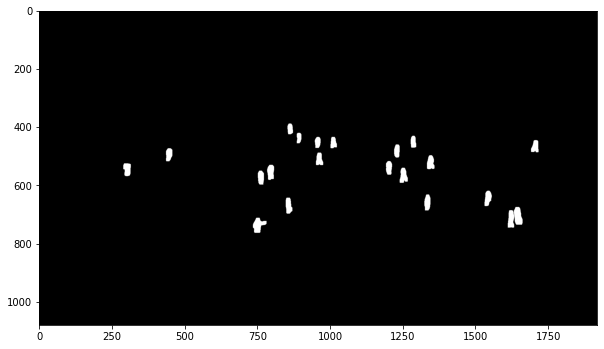

In [17]:
plt.figure(figsize=(10,20))
plt.imshow(dilated_person_mask, cmap='gray')
plt.show()

In [18]:
#invert person mask
inverted_person_mask = 1 - dilated_person_mask

In [19]:
#remove the persons from the edges
mask_a = edges.squeeze().astype(np.uint8)
mask_b = inverted_person_mask.squeeze().astype(np.uint8)
image_without_persons = np.bitwise_and(mask_b, mask_a)

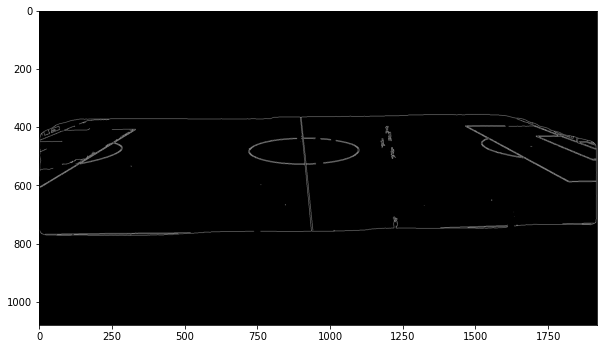

In [20]:
plt.figure(figsize=(10,20))
plt.imshow(image_without_persons, cmap='gray')
plt.show()

In [21]:
kernel = np.ones((3,3),np.uint8)
dilation = cv2.dilate(image_without_persons, kernel, iterations = 3).astype(np.uint8)

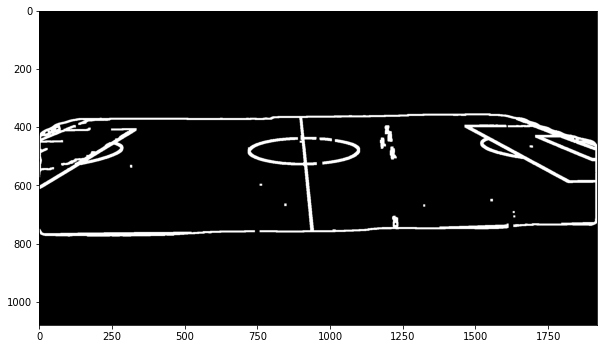

In [22]:
plt.figure(figsize=(10,20))
plt.imshow(dilation, cmap='gray')
plt.show()

In [51]:
kernel = np.ones((2,8),np.uint8)
erosion = cv2.erode(dilation ,kernel,iterations = 1)

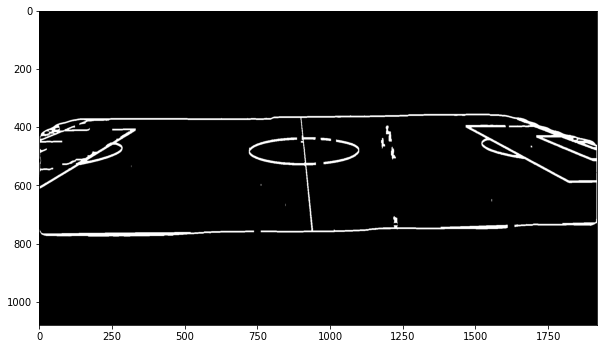

In [52]:
plt.figure(figsize=(10,20))
plt.imshow(erosion, cmap='gray')
plt.show()

In [53]:
erosion = erosion.astype(np.uint8)
mask_blurred = cv2.medianBlur(erosion, 5)

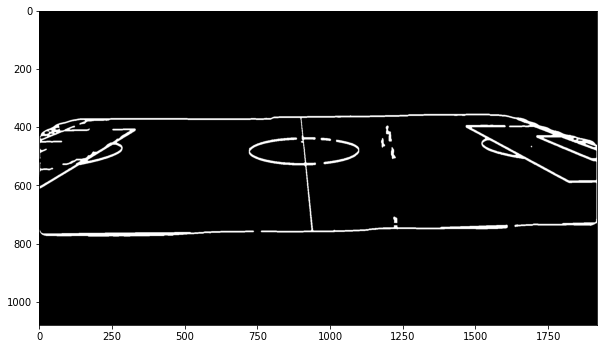

In [54]:
plt.figure(figsize=(10,20))
plt.imshow(mask_blurred, cmap='gray')
plt.show()

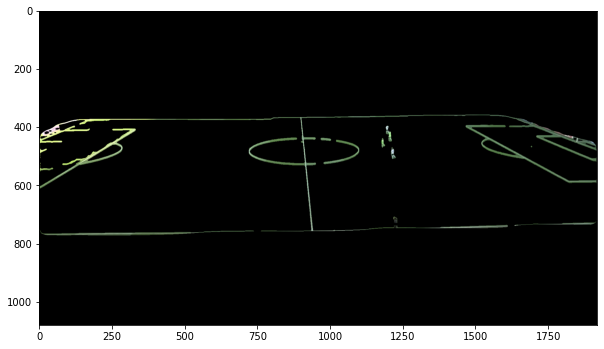

In [56]:
field_rgb = cv2.cvtColor(img3d, cv2.COLOR_BGR2RGB)
field_masked = cv2.bitwise_and(field_rgb, field_rgb, mask=mask_blurred)
plt.figure(figsize=(10,20))
plt.imshow(field_masked, cmap='gray')
plt.show()

In [57]:
gray3d = cv2.cvtColor(field_masked, cv2.COLOR_BGR2GRAY)

In [71]:
#transform every pixel to 0 or 255
gray3d[gray3d > 0] = 255

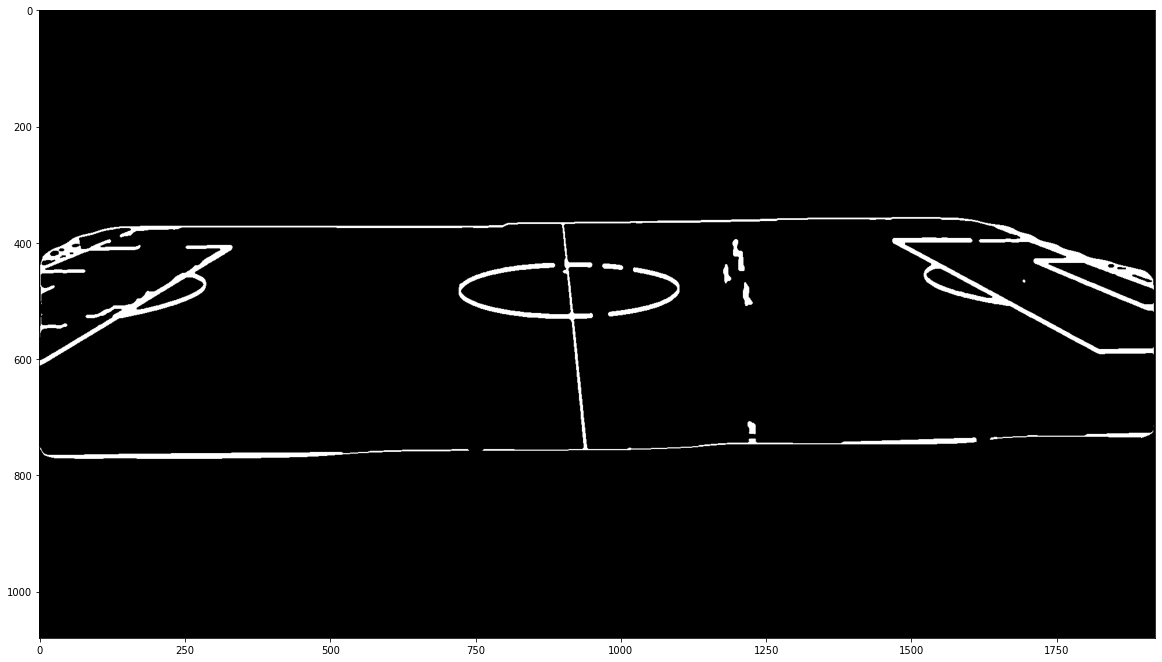

In [72]:
plt.figure(figsize=(20,40))
plt.imshow(gray3d, cmap='gray')
plt.show()

In [73]:
# Create a SIFT object
sift = cv2.SIFT_create()

In [74]:
# Detect keypoints and compute descriptors in the 2D image
keypoints2d, descriptors2d = sift.detectAndCompute(gray2d, None)

# Detect keypoints and compute descriptors in the 3D image
keypoints3d, descriptors3d = sift.detectAndCompute(gray3d, None)

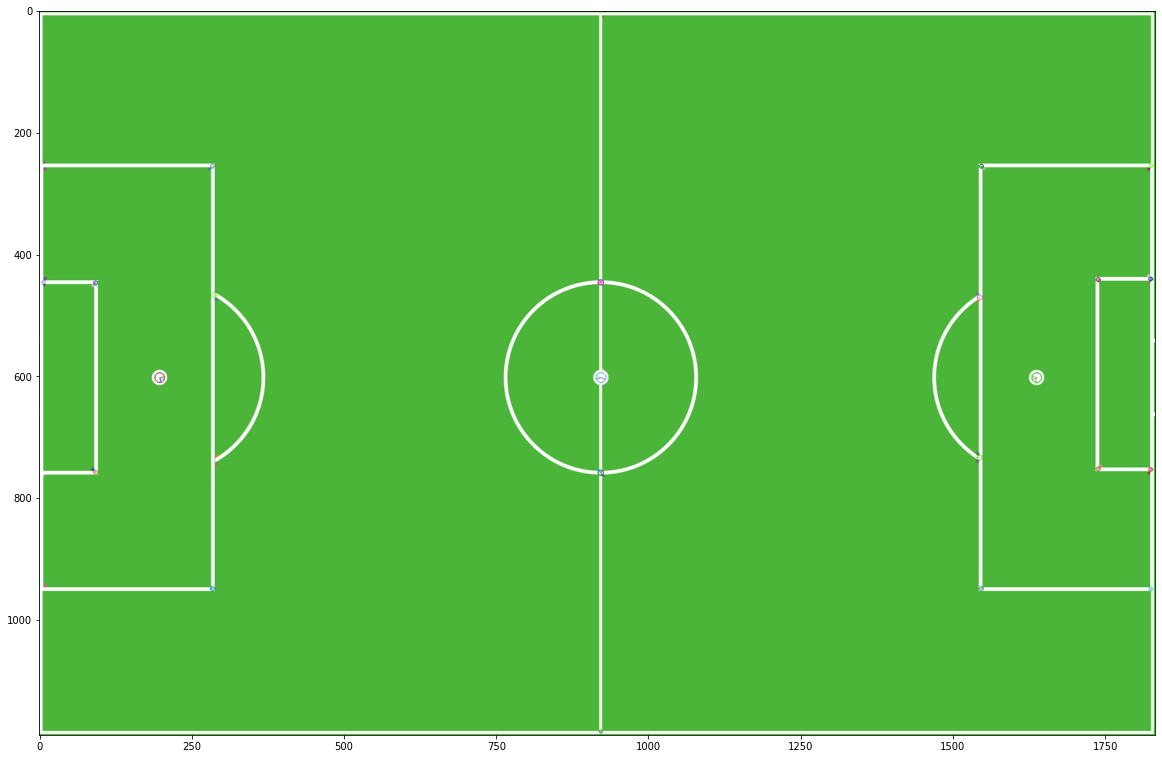

In [75]:
#print 2d image with the keypoints with a huge radius
test_sift=cv2.drawKeypoints(img2d, keypoints2d, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
plt.figure(figsize=(20,40))
plt.imshow(test_sift)
plt.show()

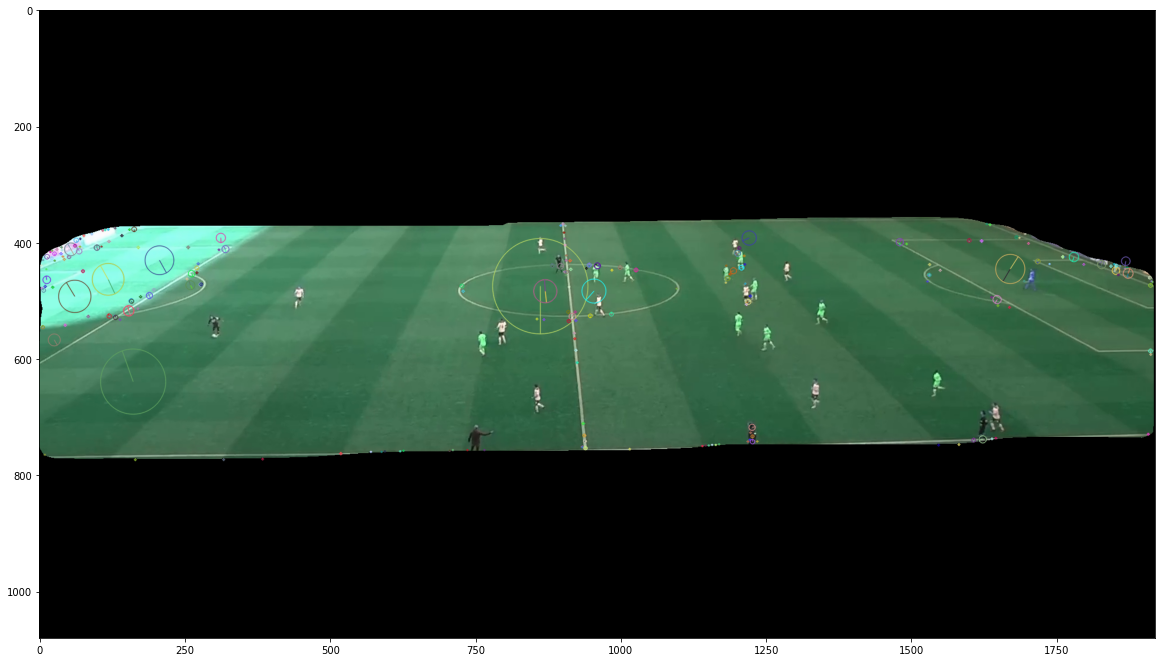

In [76]:
#print 2d image with the keypoints with a huge radius
test_sift=cv2.drawKeypoints(img3d, keypoints3d, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
plt.figure(figsize=(20,40))
plt.imshow(test_sift)
plt.show()

In [77]:
# Create a BruteForce Matcher object
bf = cv2.BFMatcher()

In [78]:
# Match the keypoints and descriptors between the 2D and 3D images
matches = bf.match(descriptors2d, descriptors3d)

In [79]:
# Sort the matches by distance
matches = sorted(matches, key = lambda x:x.distance)

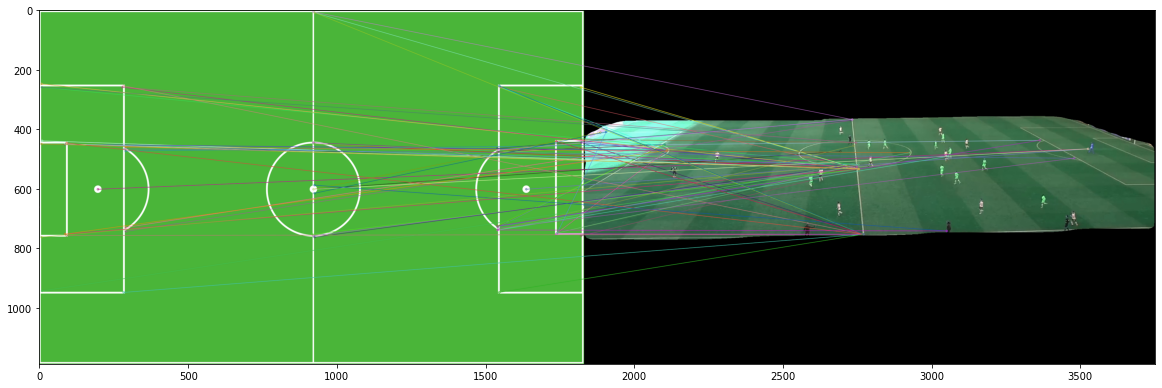

In [80]:
#draw all the best matches one by one
img3 = cv2.drawMatches(img2d, keypoints2d, img3d, keypoints3d, matches[:100], None, flags=2)
plt.figure(figsize=(20,40))
plt.imshow(img3)
plt.show()

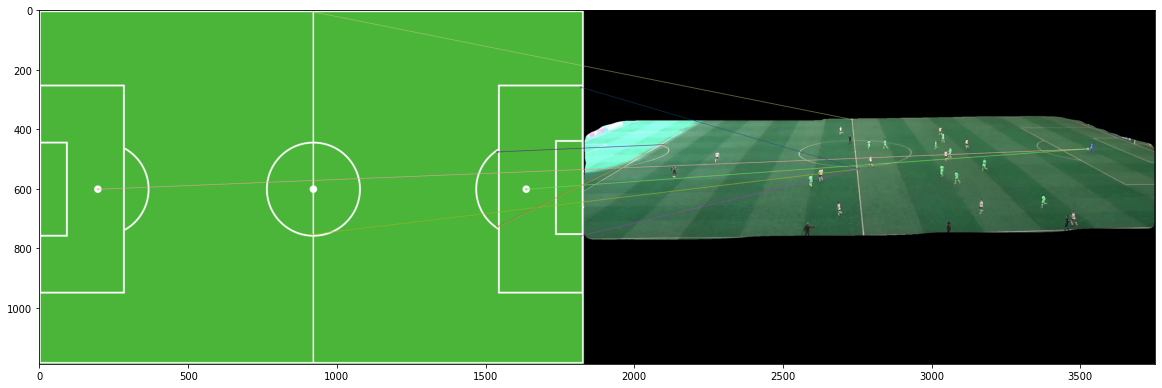

In [82]:
# Draw the first 10 matches with radius 10
img3 = cv2.drawMatches(img2d, keypoints2d, img3d, keypoints3d, matches[:15], None, flags=2)
plt.figure(figsize=(20,40))
plt.imshow(img3)
plt.show()

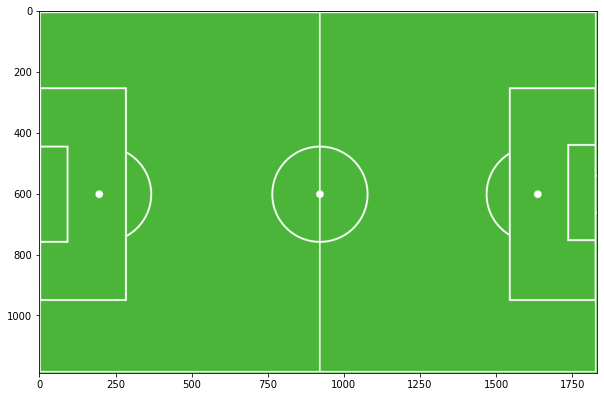

In [83]:
plt.figure(figsize=(10,20))
plt.imshow(img2d)
plt.show()

In [ ]:
plt.figure(figsize=(10,20))
plt.imshow(img3d)
plt.show()